In [14]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from keras.utils import plot_model
from training import train, create_training_folder, create_callbacks, step_decay_exp
from tcn import TCN, tcn_full_summary

import keras.backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tcn_mod import TCN

from tensorflow.keras.layers import Embedding, Dense, Input, BatchNormalization, GlobalAveragePooling1D,\
    Activation, Reshape, Conv1D, Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.regularizers import l1, l2

from training import train, create_training_folder


In [2]:
def load_model(file_name):
    loaded_model = keras.models.load_model(file_name)
    return loaded_model

In [3]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [4]:

df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 11]
X = sample[:, 3:11]
sequence_length = X.shape[-1]

# X = one_hot_encoding_X(X, vocab_size=vocab_size)
y = to_categorical(y)
# random train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    

print(np.unique(y_train).shape)

print("===Train/test size: {}, {}".format(len(y_train), len(y_test)))

Using sample size: (31373, 12)
(2,)
===Train/test size: 21961, 9412


In [5]:
crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["idx"].values.tolist()

In [31]:


def tcn(sequence_length, embeddings, layer_size = 256):
    input = Input(shape=(sequence_length,))
    x = Embedding(vocab_size, embedding_size,input_length=sequence_length)(input)
    x = BatchNormalization()(x)
    x = TCN(nb_filters=layer_size, return_sequences=True, nb_stacks=2,
            dilations=[1, 2, 4],
            use_batch_norm=True, dropout_rate=0.3)(x)
#             kernel_regularizer=l1(0.001)
#             activity_regularizer=l2(0.001)
#            )(x) 
    x = GlobalAveragePooling1D()(x)
    x = Activation("relu")(x)
    x = Dense(vocab_size, activation='relu')(x)  # classification
    model = Model(input,x)

    return model
    

def conv1d_base(vocab_size=27, sequence_length=8):
    input = Input(shape=(sequence_length,1))
    #     x =  Reshape((-1, 1))(input)
#     input_shape=(n_timesteps,n_features)
    

    x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding="same")(input)
    x = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu')(x)
    x = Flatten()(x)
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(4))
# #     model.add(Dropout(0.5))
#     model.add(GlobalMaxPooling1D())
#     model.add(MaxPooling1D(pool_size=3))
    x = Dense(128, activation='relu')(x)
#     model.add(BatchNormalization())
    output = Dense(vocab_size, activation='relu')(x)

    return Model(input, output)


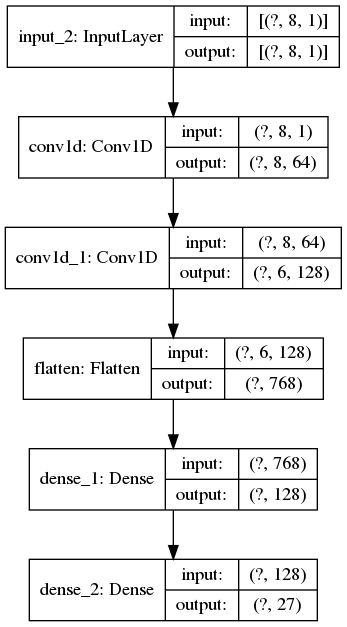

In [32]:

K.clear_session()
sequence_length = 8
vocab_size, embedding_size = (27, 20)
# model = hydrid(sequence_length, (vocab_size, embedding_size))
model = tcn(sequence_length, (vocab_size, embedding_size))
model = conv1d_base()

tag = "globaavg"

plot_model(model, show_shapes = True)

In [33]:
K.clear_session()

training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

model.compile(**training_params)

epochs=100
exp_base = "tcnv3"
folder = create_training_folder(exp_base, tag)

# lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)


train(model, X_train, y_train, X_test, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)



/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


Epoch 1/100

Epoch 00001: val_f1 improved from -inf to 0.14388, saving model to /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200809_075953_globaavg
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200809_075953_globaavg/assets
687/687 - 2s - loss: 0.8371 - f1: 0.1625 - val_loss: 0.8558 - val_f1: 0.1439
Epoch 2/100

Epoch 00002: val_f1 improved from 0.14388 to 0.23152, saving model to /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200809_075953_globaavg
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200809_075953_globaavg/assets
687/687 - 2s - loss: 0.7917 - f1: 0.2083 - val_loss: 0.7681 - val_f1: 0.2315
Epoch 3/100

Epoch 00003: val_f1 improved from 0.23152 to 0.24441, saving model to /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200809_075953_globaavg
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200809_075953_globaavg/assets
687/687 - 2s - loss: 0.7

687/687 - 2s - loss: 0.6964 - f1: 0.3033 - val_loss: 0.7007 - val_f1: 0.2983
Epoch 38/100

Epoch 00038: val_f1 improved from 0.29829 to 0.30000, saving model to /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200809_075953_globaavg
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200809_075953_globaavg/assets
687/687 - 2s - loss: 0.6893 - f1: 0.3104 - val_loss: 0.6991 - val_f1: 0.3000
Epoch 39/100

Epoch 00039: val_f1 did not improve from 0.30000
687/687 - 2s - loss: 0.6863 - f1: 0.3135 - val_loss: 0.7054 - val_f1: 0.2937
Epoch 40/100

Epoch 00040: val_f1 did not improve from 0.30000
687/687 - 2s - loss: 0.6937 - f1: 0.3060 - val_loss: 0.7311 - val_f1: 0.2681
Epoch 41/100

Epoch 00041: val_f1 did not improve from 0.30000
687/687 - 2s - loss: 0.6942 - f1: 0.3057 - val_loss: 0.7110 - val_f1: 0.2881
Epoch 42/100

Epoch 00042: val_f1 did not improve from 0.30000
687/687 - 2s - loss: 0.6887 - f1: 0.3110 - val_loss: 0.7157 - val_f1: 0.2835
Epoch 43/1

/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Confusion matrix, without normalization


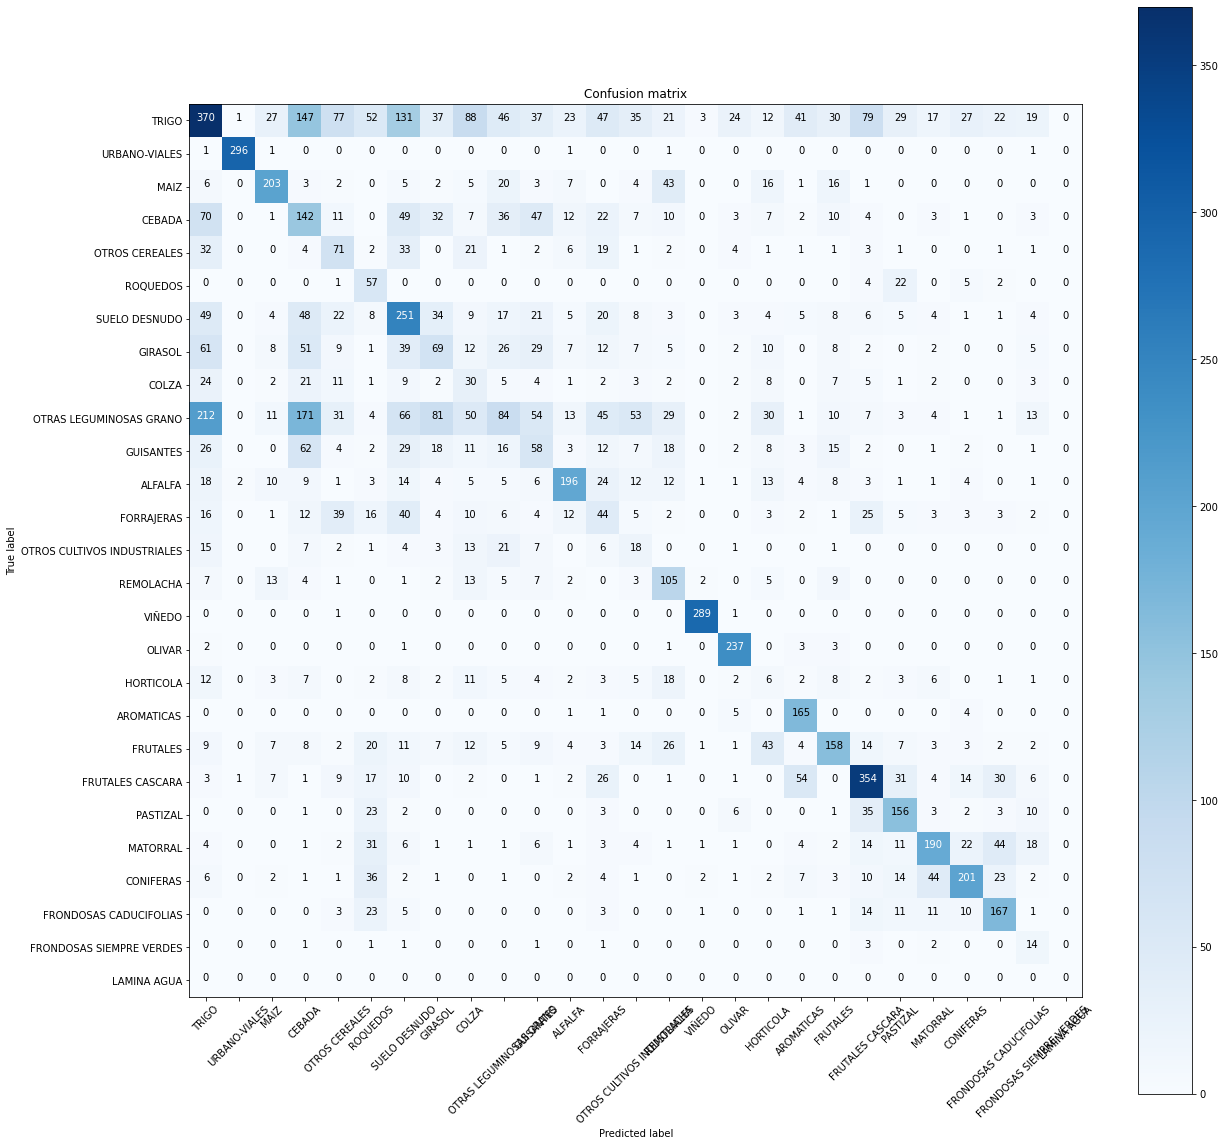

In [9]:
# evaluate
y_hat = model.predict(X_test)
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)


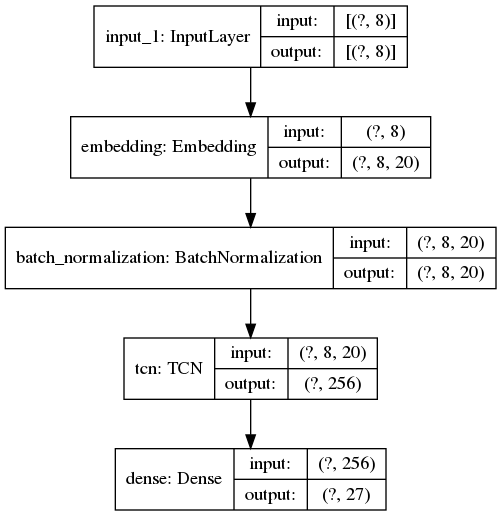

In [10]:
plot_model(model, show_shapes=True)

/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Confusion matrix, without normalization


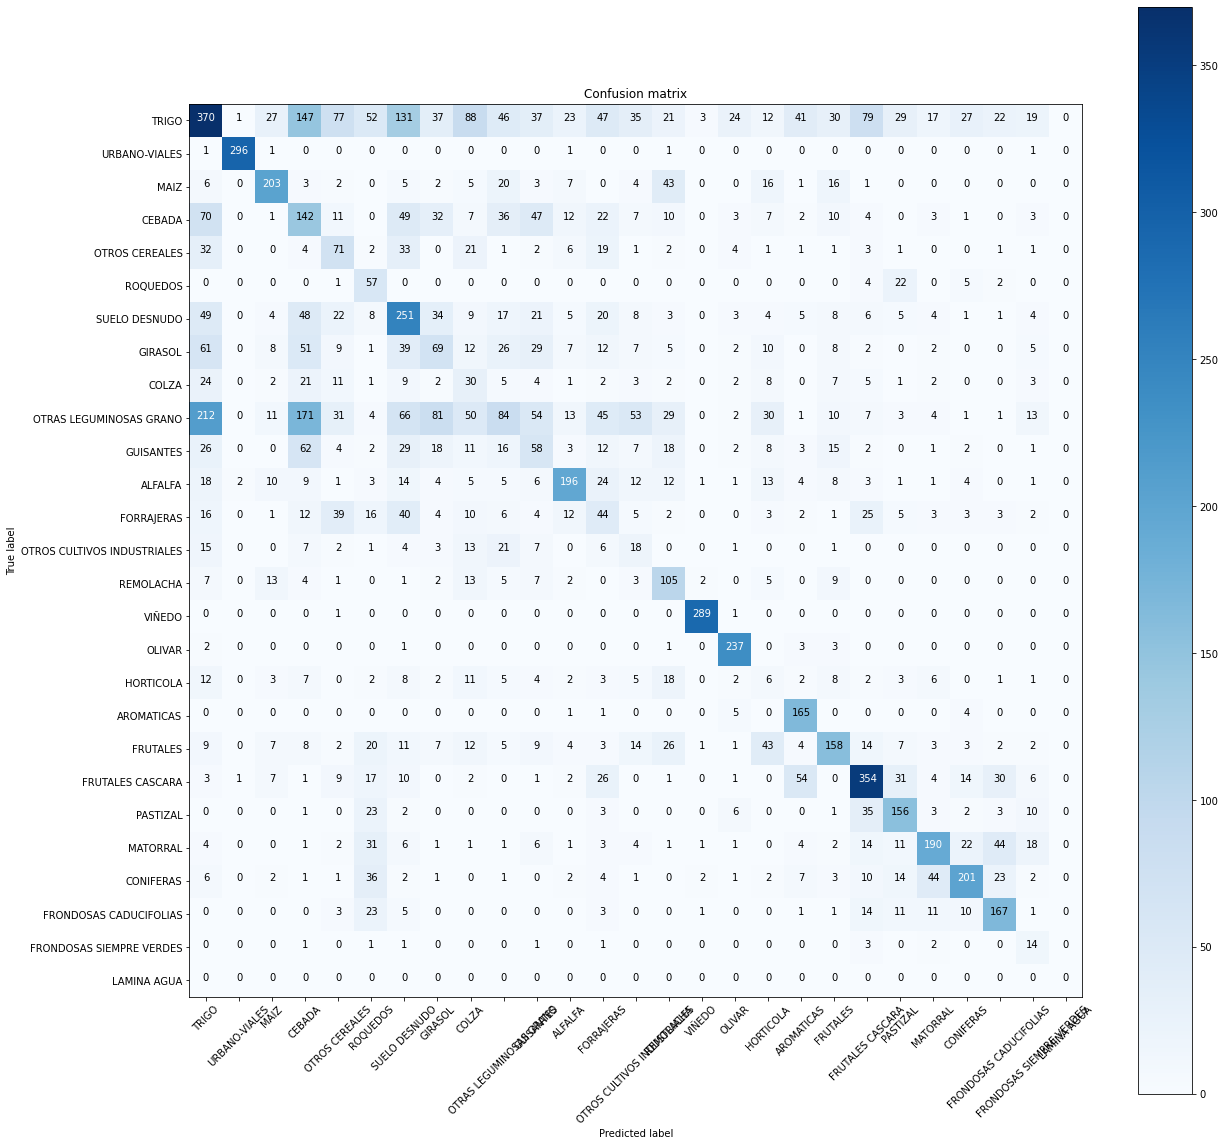

In [11]:
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)